## Extract TLD in Canvas Fingerprinting scripts

This notebook extracts the TLDs for script_url and location in Canvas Fingerprinting scripts. The heuristics to find out the Canvas Fingerprinting scripts is directly taken from [2019_03_willougr_fingerprinting_implementation_sixth_sense/Canvas Fingerprinting Heuristics](https://github.com/mozilla/overscripted/blob/master/analyses/2019_03_willougr_fingerprinting_implementation_sixth_sense/Canvas%20Fingerprinting%20Heuristics.ipynb).

In [45]:
import pandas as pd
import dask.dataframe as dd
import os
import re
import json
from collections import Counter
from dask.distributed import Client, progress
from pandas.api.types import CategoricalDtype

DATA_DIR = 'YOUR DATA DIRECTORY HERE'
DATA_DIR_FULL ='/home/soumya/Dataset/sample_0.parquet'

In [4]:
Client()

/home/soumya/.conda/envs/overscripted/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:40275 Dashboard: http://127.0.0.1:39631/status,Cluster Workers: 4 Cores: 12 Memory: 8.25 GB


# Build candidates

In [5]:
df_to_data_urls_df = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'symbol'])
df_to_data_urls_df = df_to_data_urls_df[df_to_data_urls_df.symbol == 'HTMLCanvasElement.toDataURL']
to_data_urls = df_to_data_urls_df.script_url.unique().compute()
to_data_urls[0:5]

/home/soumya/.local/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


0     https://www.coches.net/ztkieflaaxcvaiwh121837.js
1      http://static.mvideo.ru/media/js/mvideo.js?v0.7
2        https://misc.gomein.net.cn/js/regfront/gfp.js
3         http://www.elcorteingles.es/akam/10/240f2be0
4    https://player.mais.uol.com.br/js/uolplayer.mi...
Name: script_url, dtype: object

In [6]:
def large_enough(row):
    width = float(row.argument_2)
    height = float(row.argument_3)
    return width >= 16 and height >= 16

df_get_image_data_df = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'symbol', 'argument_2', 'argument_3'])
df_get_image_data_df = df_get_image_data_df[df_get_image_data_df.symbol == 'CanvasRenderingContext2D.getImageData']
df_get_image_data_df = df_get_image_data_df[df_get_image_data_df.apply(large_enough, axis=1, meta=('bool'))]
get_image_data_urls = df_get_image_data_df.script_url.unique().compute()
get_image_data_urls[0:5]

0    http://ue.17173cdn.com/a/newgame/index/2017/v3...
1                       resource://pdf.js/build/pdf.js
2           http://cdn.promodj.com/core/core.js?1ce4f0
3    https://s0.2mdn.net/ads/studio/cached_libs/cre...
4    https://www.youtube.com/yts/jsbin/player-vflyo...
Name: script_url, dtype: object

In [7]:
print('n to_data_urls', len(to_data_urls))
print('n get_image_data_urls', len(get_image_data_urls))
candidate_urls = to_data_urls.append(get_image_data_urls).unique()
print('n candidate urls', len(candidate_urls))

n to_data_urls 3441
n get_image_data_urls 95
n candidate urls 3530


In [8]:
all_candidate_urls = candidate_urls.copy()

# Start removing

## 1. Remove manually filtered

In [9]:
false_positive_script_urls = {
    'http://www.fivola.com/',
    'http://cdn02.centraledachats.be/dist/js/holder.js',
    'http://ccmedia.fr/accueil.php',
    'http://rozup.ir/up/moisrex/themes/space_theme/script.js'
}

In [10]:
candidate_urls = [url for url in candidate_urls if url not in false_positive_script_urls]
print('n candidate urls', len(candidate_urls))

n candidate urls 3530


In [11]:
print(len(set(all_candidate_urls) - set(candidate_urls)))
disgarded_urls = [url for url in all_candidate_urls if url not in candidate_urls]
with open('not_canvas_fingerprinting_1.json', 'w') as f:
    f.write(json.dumps(disgarded_urls)) 

0


## 2. Remove save, restore, addEventListener

In [12]:
df_valid_calls_df = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'symbol'])
df_valid_calls_df = df_valid_calls_df[df_valid_calls_df.symbol.isin(
    ['CanvasRenderingContext2D.save', 'CanvasRenderingContext2D.restore', 'HTMLCanvasElement.addEventListener']
)]
valid_calls_urls = df_valid_calls_df.script_url.unique().values.compute()
valid_calls_urls[0:5]

array(['https://s0.2mdn.net/ads/studio/cached_libs/createjs_2015.11.26_54e1c3722102182bb133912ad4442e19_min.js',
       'https://audience-x.linkstorm.net/CNST/CNST_AX17_2C03/libs/createjs-2015.11.26.min.js',
       'https://cdn4.forter.com/script.js?sn=d379f257f86d',
       'https://code.createjs.com/createjs-2015.11.26.min.js',
       'https://widget.sndcdn.com/single-sound-97ef94a-bcf2172b.js'],
      dtype=object)

In [13]:
candidate_urls = [url for url in candidate_urls if url not in valid_calls_urls]
print('n candidate urls', len(candidate_urls))

n candidate urls 3494


In [14]:
len(set(all_candidate_urls) - set(candidate_urls))

36

In [15]:
print(len(set(all_candidate_urls) - set(candidate_urls)))
disgarded_urls = [url for url in all_candidate_urls if url not in candidate_urls]
with open('not_canvas_fingerprinting_2.json', 'w') as f:
    f.write(json.dumps(disgarded_urls)) 

36


## 3. Must have written 10 or more characters

In [16]:
## Code sourced from: github.com/sensor-js/OpenWPM-mobile/blob/mobile_sensors/feature_extraction/extract_features.py

def text_length(arg_0):
    return len(arg_0.encode('ascii', 'ignore'))

In [18]:
df_write = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'symbol', 'argument_0'])
df_write = df_write[df_write.script_url.isin(candidate_urls)]
df_write = df_write[df_write.symbol.isin(['CanvasRenderingContext2D.fillText', 'CanvasRenderingContext2D.strokeText'])]
df_write['len_arg'] = df_write.argument_0.apply(text_length, meta=('int'))
df_write = df_write[df_write.len_arg >= 10]
df_write = df_write.compute()
df_write.head()

,script_url,symbol,argument_0,len_arg
call_id,,,,
1_00022de65942197e3855f68b373c5a2710eefe66945e40063c30419f.json__269,https://www.coches.net/ztkieflaaxcvaiwh121837.js,CanvasRenderingContext2D.fillText,"Cwm fjordbank glyphs vext quiz, 😃",32
1_00022de65942197e3855f68b373c5a2710eefe66945e40063c30419f.json__272,https://www.coches.net/ztkieflaaxcvaiwh121837.js,CanvasRenderingContext2D.fillText,"Cwm fjordbank glyphs vext quiz, 😃",32
1_0004d550953191c5723947694ac872f7e277d94041ae0112ffa577fd.json__355,http://static.mvideo.ru/media/js/mvideo.js?v0.7,CanvasRenderingContext2D.fillText,sans-serif,10
1_0004d550953191c5723947694ac872f7e277d94041ae0112ffa577fd.json__360,http://static.mvideo.ru/media/js/mvideo.js?v0.7,CanvasRenderingContext2D.fillText,Abadi MT Condensed,18
1_0004d550953191c5723947694ac872f7e277d94041ae0112ffa577fd.json__361,http://static.mvideo.ru/media/js/mvideo.js?v0.7,CanvasRenderingContext2D.fillText,Abadi MT Condensed Light,24


In [19]:
too_many_write_urls = df_write.script_url.unique()
print('n "3 too long writes" urls', len(too_many_write_urls))

n "3 too long writes" urls 1473


## Apply 3

In [20]:
text_filter = set(too_many_write_urls)
candidate_urls = list(text_filter)

In [21]:
print(len(set(all_candidate_urls) - set(candidate_urls)))
disgarded_urls = [url for url in all_candidate_urls if url not in candidate_urls]
with open('not_canvas_fingerprinting_3.json', 'w') as f:
    f.write(json.dumps(disgarded_urls)) 

2057


In [22]:
with open('canvas_fingerprinting.json', 'w') as f:
    f.write(json.dumps(candidate_urls))

In [23]:
with open('not_canvas_fingerprinting.json', 'w') as f:
    f.write(json.dumps(disgarded_urls))

## Find Locations

In [24]:
with open('canvas_fingerprinting.json', 'r') as f:
    canvas_fp_urls = json.load(f)
    
print(len(canvas_fp_urls), '== 8514')

1473 == 8514


In [25]:
df = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'location'])

In [26]:
df_locs = df[df.script_url.isin(canvas_fp_urls)]
locs = df_locs.location.unique().persist()
progress(locs, notebook=False)

In [27]:
print('# of locations that call canvas fingerprinting scripts:', len(locs))

# of locations that call canvas fingerprinting scripts: 3635


In [28]:
canvas_fp_urls[0:10]

['https://t1.musthird.com/fp/check.js;CIS3SID=4E51E3E73109CE40317785FAF9D0C0F8?org_id=kfgn8s24&session_id=1513425323--6e0cdf24c35fe76e7baebfa2&nonce=9773a775ce6207d3&pageid=1',
 'http://squid.gazeta.pl/bdtrck/getBdIf?domain=www.blox.pl&visitedUrl=http%3A%2F%2Fwww.blox.pl%2Fblog%2Findex%2Fpolecane&scriptversion=2.0.0&rnd=3283990017211744&gfkmedia=bloxPL&gfkroot=own&gfktype=rwd&',
 'https://www.ae.com/akam/10/690520a8',
 'http://www.yad2.co.il/sbbi/?sbbpg=sbbShell&gprid=CE&sbbgs=h4a7c247d36341de32bb98615beceba7f972&ddl=2',
 'https://zc.reg.163.com/resources/mp-agent-finger.html?WEBZJVersion=1512468208810&pkid=cBkgQOW&product=qn',
 'https://fstrk.net/api/tracker/9872ed9fc22fc182d371c3e9ed316094/landing.js',
 'https://cdn1.cerebroad.com/libs/adsloader-151334218860885a33c4ec94a3d627046455.js',
 'https://www.mrporter.com/akam/10/4e5df926',
 'http://webresource.c-ctrip.com/resaresonline/risk/ubtrms/d.min.b1da08d8.js',
 'http://static.fraudmetrix.cn/fm.js?ver=0.1&t=420407']

In [29]:
location=locs.compute()
location[0:10]

0            https://www.coches.net/fiat/segunda-mano/
1    http://www.mvideo.ru/aksessuary-dlya-avtomobil...
2        https://torrentsgroup.com/torrents.php?cat=49
3    https://shop.nordstrom.com/c/beauty-new?origin...
4        https://reg.gome.com.cn/register/index/person
5    http://www.elcorteingles.es/moda/accesorios/es...
6    https://www.macys.com/shop/jewelry-watches/nec...
7    https://player.mais.uol.com.br/index.html?medi...
8    https://www.macys.com/shop/kitchen/kitchen-gif...
9    https://www.linkedin.com/authwall?trk=bf&trkIn...
Name: location, dtype: object

## Extract TLD For script_url

In [30]:
import tldextract
opsuffix=[]
opurls=[]
for i in range(len(canvas_fp_urls)):
    opurls.append(tldextract.extract(canvas_fp_urls[i]))
    opsuffix.append(opurls[i].suffix)
print(opsuffix[0:20])

['com', 'pl', 'com', 'co.il', 'com', 'net', 'com', 'com', 'com', 'cn', 'com', 'com', 'com', 'com', 'com', 'it', 'com', 'network', 'net', 'com']


In [31]:
len(canvas_fp_urls)

1473

## Extract TLD For location

In [32]:
opsuffix_locs=[]
opurls_locs=[]
for i in range(len(locs)):
    opurls_locs.append(tldextract.extract(location[i]))
    opsuffix_locs.append(opurls_locs[i].suffix)
print(opsuffix_locs[0:20])

['net', 'ru', 'com', 'com', 'com.cn', 'es', 'com', 'com.br', 'com', 'com', 'com', 'com', 'com', 'com', 'com', 'com', 'cz', 'com', 'com', 'com']


## Frequency of each TLD for script_url

In [33]:
import collections
for i in range(len(opsuffix)):
    counter_script_url=collections.Counter(opsuffix)
print(counter_script_url)

Counter({'com': 851, 'network': 118, 'net': 96, 'es': 83, 'cn': 52, 'de': 44, 'ca': 36, 'co.uk': 35, 'it': 23, 'co.jp': 15, 'pl': 12, 'com.tw': 10, 'fr': 10, 'ru': 8, 'io': 8, 'ws': 6, 'com.br': 6, 'ch': 6, 'org': 5, 'in': 4, 'sexy': 4, '': 3, 'hk': 3, 'nl': 3, 'cz': 3, 'tv': 2, 'az': 2, 'vn': 2, 'vc': 2, 'cc': 2, 'ly': 2, 're': 2, 'co.il': 1, 'sk': 1, 'net.cn': 1, 'jp': 1, 'dhl': 1, 'gs': 1, 'systems': 1, 'biz': 1, 'com.au': 1, 'pub': 1, 'jo': 1, 'ai': 1, 'st': 1, 'pro': 1, 'org.br': 1})


In [34]:
#Store in a Json file
with open('canvas_script_url.json', 'w') as f:
    f.write(json.dumps(counter_script_url)) 

In [35]:
len(counter_script_url)

47

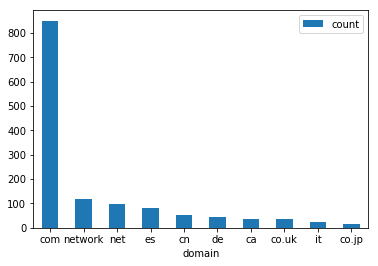

In [46]:
# Arange in descending order    
c=Counter(counter_script_url)
counter_script_url=dict(c.most_common())
#Convert to list for plotting
domain=list(counter_script_url.keys())
count=list(counter_script_url.values())

dfplot = pd.DataFrame({'domain':domain[0:10], 'count':count[0:10]})
ax = dfplot.plot.bar(x='domain', y='count', rot=0)

# Frequency of each TLD for location

In [37]:
for i in range(len(locs)):
    counter_location=collections.Counter(opsuffix_locs)
print(counter_location)

Counter({'com': 2235, 'net': 182, 'es': 137, 'network': 112, 'de': 93, 'fr': 74, 'it': 74, 'co.uk': 74, 'cn': 69, 'ru': 68, 'ca': 57, 'org': 40, 'com.tw': 31, 'tv': 28, 'co': 26, 'gov': 24, 'pl': 21, 'cz': 20, 'jp': 20, 'ws': 20, 'cc': 18, 'sc': 18, 'co.jp': 18, 'vn': 17, 'com.br': 16, 'in': 15, 'ch': 11, 'com.cn': 10, 'edu': 10, 'lol': 9, 'io': 8, 'ac.uk': 7, 'com.hk': 5, 'biz': 5, 'sexy': 4, 'com.vn': 4, 'hk': 4, 'co.il': 4, 'az': 4, 'to': 3, 'ie': 3, 'sk': 3, 'zone': 3, 'com.au': 3, 'nl': 3, 'watch': 3, 'at': 2, 'ec': 2, 'club': 2, 'bz': 2, 'com.tr': 2, 'vc': 2, 'dhl': 1, 'pw': 1, 'co.za': 1, 'co.kr': 1, 'no': 1, 'eu': 1, 'gp': 1, 'jo': 1, 'com.uy': 1, 'co.th': 1})


In [38]:
counter_location

Counter({'net': 182,
         'ru': 68,
         'com': 2235,
         'com.cn': 10,
         'es': 137,
         'com.br': 16,
         'cz': 20,
         'network': 112,
         'edu': 10,
         'fr': 74,
         'cc': 18,
         'pl': 21,
         'it': 74,
         'de': 93,
         'tv': 28,
         'com.hk': 5,
         'co': 26,
         'ch': 11,
         'com.tw': 31,
         'co.uk': 74,
         'org': 40,
         'ca': 57,
         'cn': 69,
         'vn': 17,
         'gov': 24,
         'at': 2,
         'dhl': 1,
         'jp': 20,
         'sc': 18,
         'sexy': 4,
         'to': 3,
         'com.vn': 4,
         'co.jp': 18,
         'hk': 4,
         'ie': 3,
         'ac.uk': 7,
         'ws': 20,
         'in': 15,
         'co.il': 4,
         'lol': 9,
         'pw': 1,
         'io': 8,
         'ec': 2,
         'sk': 3,
         'zone': 3,
         'com.au': 3,
         'az': 4,
         'co.za': 1,
         'co.kr': 1,
         'no': 1,
        

In [39]:
# Store in a json  file
with open('canvas_location.json', 'w') as f:
    f.write(json.dumps(counter_location)) 

In [40]:
len(counter_location)

62

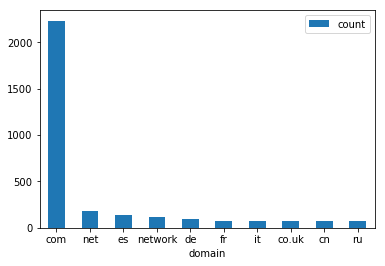

In [47]:
# Arange in descending order    
c=Counter(counter_location)
counter_location=dict(c.most_common())
#Convert to list for plotting
domain=list(counter_location.keys())
count=list(counter_location.values())

dfplot = pd.DataFrame({'domain':domain[0:10], 'count':count[0:10]})
ax = dfplot.plot.bar(x='domain', y='count', rot=0)